How to make SVG without X11: http://matplotlib.org/faq/howto_faq.html#matplotlib-in-a-web-application-server

How to embed in django: make SVG, replace in template http://stackoverflow.com/questions/34958702/embedding-a-matplotlib-plot-within-a-django-site

Alternatively, make PNG and embed as base64


In [1]:
%qtconsole

In [2]:
import pickle
import matplotlib
matplotlib.use('Agg')
import pandas as pd
from IPython.display import SVG, display


In [3]:
pd=pickle.load(open("pd.pickle","rb"))


Please cite -- HTMD: High-Throughput Molecular Dynamics for Molecular Discovery
J. Chem. Theory Comput., 2016, 12 (4), pp 1845-1852. 
http://pubs.acs.org/doi/abs/10.1021/acs.jctc.6b00049

You are on the latest HTMD version (unpackaged : /home/toni/work/htmd/htmd/htmd).



In [22]:
def get_pka_plot(prepData, pH=7.4, figSize=(8,10), style=1):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import LinearSegmentedColormap
    
    
    # Shading
    C = 5
    X = np.array([range(C),range(C)])
    X = np.array([[1,1,1,1,1,1,1,0],[1,1,1,1,1,1,1,0]])
    
    # Shading colors http://matplotlib.org/examples/pylab_examples/custom_cmap.html
    neutral_grey = (.7,.7,.7)
    grey_red = LinearSegmentedColormap.from_list("grey_red",[neutral_grey,(1, 0, 0) ] )
    grey_blue = LinearSegmentedColormap.from_list("grey_blue",[neutral_grey,(0, 0, 1) ] )
    
    # Color for pk values
    pkcolor = "black"
    pkfontsize = 10

    
    # Constants
    acidicResidues = ['ASP','GLU','TYR']
    basicResidues = ['HIS','LYS','ARG']
    
    # titr =  (~ pd.isnull(d.pKa)) & d.pKa < 99
    d = prepData.data
    titr =  d.pKa < 99  # Automatically excludes NaN
    N = sum(titr)
    
    # Format residue labels
    labels = [x.resname+" "+str(x.resid)+x.insertion for i,x in d.loc[titr].iterrows()]
    pKas = d.pKa.loc[titr]
    restypes = ["neg" if x.resname in acidicResidues else "pos" for i,x in d.loc[titr].iterrows() ]
    

    xmin, xmax = xlim = 0, 14
    ymin, ymax = ylim = -1, N

    #fig = figure(figsize=figSize)
    fig = plt.figure(figsize=figSize)
    ax = fig.add_subplot(111, xlim=xlim, ylim=ylim,
                         autoscale_on=False)

    ax.xaxis.tick_top()
    ax.set_xlabel("pKa")
    ax.xaxis.set_label_position('top') 

    ax.yaxis.set_ticks(range(N))
    ax.yaxis.set_ticklabels(labels)
    ax.invert_yaxis()

    width=.7
    for i in range(N):
        left=xmin
        right=xmax
        top=i+width/2
        bottom=i-width/2
        pk = pKas.iloc[i]
        restype = restypes[i]
        
        if style==1:
            if restype == "neg":
                ax.imshow(np.fliplr(X), interpolation="bicubic",
                          cmap=plt.cm.Blues, vmin=0, vmax=2,
                          extent=(pk, right, bottom, top), alpha=1)
                ax.text(pk,i," {:5.2f} ".format(pk),color=pkcolor, fontsize=pkfontsize, 
                        horizontalalignment="right")
            else:
                ax.imshow(X, interpolation="bicubic",
                          cmap=plt.cm.Reds, vmin=0, vmax=2,
                          extent=(left, pk, bottom, top), alpha=1)
                ax.text(pk,i," {:5.2f} ".format(pk),color=pkcolor, fontsize=pkfontsize, 
                        horizontalalignment="left")
        elif style==2:
            ax.imshow(np.fliplr(X), interpolation="bicubic",
                          cmap=plt.cm.Blues, vmin=0, vmax=2,
                          extent=(pk, right, bottom, top), alpha=1)
            ax.imshow(X, interpolation="bicubic",
                          cmap=plt.cm.Reds, vmin=0, vmax=2,
                          extent=(left, pk, bottom, top), alpha=1)
            ax.text(pk,i," {:5.2f} ".format(pk),color=pkcolor, fontsize=pkfontsize, 
                    horizontalalignment="center")
        elif style==3:
            if restype == "neg":
                ax.imshow(X*0, interpolation="bicubic",
                          cmap=grey_blue, vmin=0, vmax=2,
                          extent=(left, pk, bottom, top), alpha=1)
                ax.imshow(np.fliplr(X), interpolation="bicubic",
                          cmap=grey_blue, vmin=0, vmax=2,
                          extent=(pk, right, bottom, top), alpha=1)
                ax.text(pk,i," {:5.2f} ".format(pk),color=pkcolor, 
                        fontsize=pkfontsize, horizontalalignment="right")
            else:
                ax.imshow(X, interpolation="bicubic",
                          cmap=grey_red, vmin=0, vmax=2,
                          extent=(left, pk, bottom, top), alpha=1)
                ax.imshow(X*0, interpolation="bicubic",
                          cmap=grey_red, vmin=0, vmax=2,
                          extent=(pk, right, bottom, top), alpha=1)
                ax.text(pk,i," {:5.2f} ".format(pk),color=pkcolor, 
                        fontsize=pkfontsize, horizontalalignment="left")
            ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='white'))

        # ax.add_line(Line2D([pk,pk], [bottom,top], linewidth=3, color='blue'))
        

    # Vertical line at pH
    ax.axvline(x=pH, linewidth=100, color="k", alpha=.2) 
    ax.axvline(x=pH, linewidth=10, color="k", alpha=.3) 

    ax.set_aspect('auto')
    
    # show()   # for interactive use
    from io import StringIO
    imgdata = StringIO()
    fig.savefig(imgdata, format="svg", bbox_inches='tight')
    plt.close(fig)
    return imgdata.getvalue()


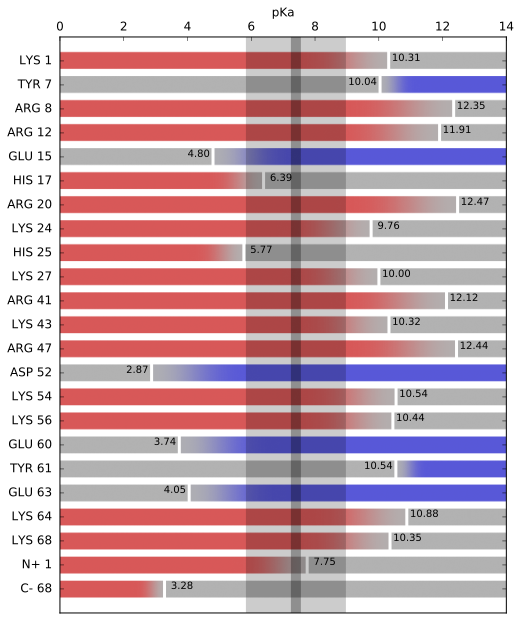

In [23]:
svg_plot=get_pka_plot(pd, pH=7.4,style=3)
display(SVG(svg_plot))

In [7]:
svg_plot[0:400]

'<?xml version="1.0" encoding="utf-8" standalone="no"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"\n  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n<!-- Created with matplotlib (http://matplotlib.org/) -->\n<svg height="735pt" version="1.1" viewBox="0 0 521 735" width="521pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">\n <defs>\n  <style type="text/css">\n*{s'

In [8]:
?SVG
